In [1]:
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns


In [6]:
tracks =pd.read_csv(r'C:\Users\Navin\Downloads\final project technocolabs\fma-rock-vs-hiphop.csv')

In [7]:
tracks.head(2)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky


In [8]:
echonest_metrics =pd.read_json(r'C:\Users\Navin\Downloads\final project technocolabs\echonest-metrics.json')

In [9]:
echonest_metrics .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          13129 non-null  int64  
 1   acousticness      13129 non-null  float64
 2   danceability      13129 non-null  float64
 3   energy            13129 non-null  float64
 4   instrumentalness  13129 non-null  float64
 5   liveness          13129 non-null  float64
 6   speechiness       13129 non-null  float64
 7   tempo             13129 non-null  float64
 8   valence           13129 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [10]:
echo_tracks = pd.merge(left = tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')

echo_tracks.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [11]:
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [12]:
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
exp_variance

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

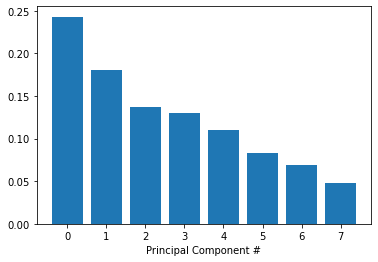

In [14]:
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()


In [16]:
import numpy as np
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

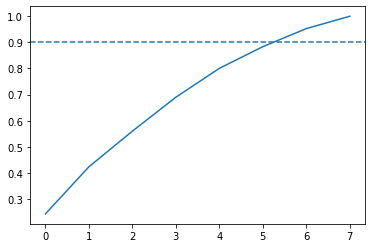

In [17]:
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [18]:
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [19]:
pca_projection.shape


(4802, 7)

In [20]:
from sklearn.model_selection import train_test_split

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, stratify = labels)

# Train our decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels_tree)

0.8509575353871773

In [22]:
labels.value_counts()


Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels_tree)

array([[143,  85],
       [ 94, 879]], dtype=int64)

In [24]:
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.63      0.62       228
        Rock       0.91      0.90      0.91       973

    accuracy                           0.85      1201
   macro avg       0.76      0.77      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.59      0.67       228
        Rock       0.91      0.96      0.93       973

    accuracy                           0.89      1201
   macro avg       0.84      0.77      0.80      1201
weighted avg       0.88      0.89      0.88      1201



In [25]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
rock_only.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [26]:
rock_only.shape, hop_only.shape


((3892, 10), (910, 10))

In [27]:
rock_only = rock_only.sample(n= hop_only.shape[0])
rock_only.shape, hop_only.shape

((910, 10), (910, 10))

In [29]:
rock_hop_bal = pd.concat([rock_only, hop_only])
rock_hop_bal.shape

(1820, 10)

In [30]:
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,
                                                                            labels,
                                                                            stratify = labels,
                                                                            random_state=10)

In [31]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.79      0.79       227
        Rock       0.79      0.78      0.78       228

    accuracy                           0.78       455
   macro avg       0.78      0.78      0.78       455
weighted avg       0.78      0.78      0.78       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.80      0.83       227
        Rock       0.81      0.86      0.84       228

    accuracy                           0.83       455
   macro avg       0.83      0.83      0.83       455
weighted avg       0.83      0.83      0.83       455



In [32]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv = kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),
      "Logistic Regression:", np.mean(logit_score))

C:\Users\Navin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Decision Tree: 0.7675824175824175 Logistic Regression: 0.8203296703296704
